In [27]:
import json
import os
from PIL import Image
import numpy as np
import pickle
from collections import namedtuple
import cv2

**Define a namedtuple containing data for each image**

In [28]:
annotationclass = namedtuple('annotationclass', ['bbox','category','keypoints','segmentation'])
imageclass = namedtuple('imageclass', ['image', 'normalized', 'annotations', 'mask'])

**Convert all the data**

In [29]:
def load_image_pixels(image_dir, image_file):
    img_path = os.path.join(image_dir, image_file)
    with Image.open(img_path) as img:
        return np.array(img)

In [30]:
json_files = ["RadioGalaxyNET_Dataset/data/RadioGalaxyNET/annotations/train.json","RadioGalaxyNET_Dataset/data/RadioGalaxyNET/annotations/test.json","RadioGalaxyNET_Dataset/data/RadioGalaxyNET/annotations/val.json"]
images_dirs = ["RadioGalaxyNET_Dataset/data/RadioGalaxyNET/train","RadioGalaxyNET_Dataset/data/RadioGalaxyNET/test","RadioGalaxyNET_Dataset/data/RadioGalaxyNET/val"]
output_files = ["train.obj","test.obj","val.obj"]

Mean size: 1470.782514450867
Standard deviation: 2245.41545480881
Min size: 96
Max size: 49621
Mode size: 600
Number of images greater than 4,096: 210
Number of images less than 4,096: 3942
Maximum width: 292
Maximum height: 347


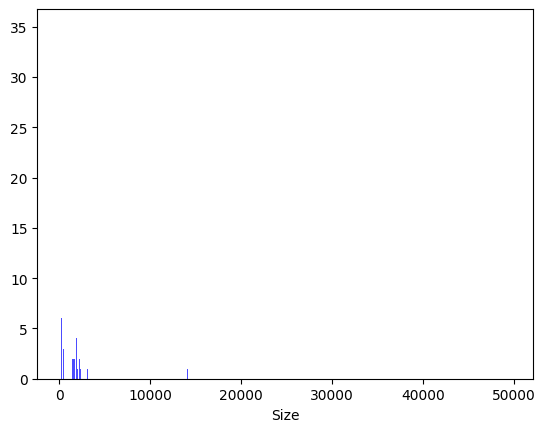

In [31]:
sizes = []
max_width = 0
max_height = 0
for jsonfile, folder, output in zip(json_files, images_dirs, output_files):
    with open(jsonfile, "r") as txt:
        json_data = json.load(txt)
        
    # Load images, annotations, and categories
    images = json_data.get('images', [])
    annotations = json_data.get('annotations', [])
    categories = {cat['id']: cat['name'] for cat in json_data.get('categories', [])}
    
    # Load annotations as annotation objects
    annotations_by_image = {}
    for annotation in annotations:
        image_id = annotation['image_id']
        bbox = annotation['bbox']
        category = annotation['category_id']
        keypoints = annotation.get('keypoints', [])
        segmentation = annotation.get('segmentation', [])
        ann = annotationclass(bbox=bbox, category=category, keypoints=keypoints, segmentation=segmentation)
        annotations_by_image.setdefault(image_id, []).append(ann)

    # Load images (for real this time)
    imgobjs = []
    for image in images:
        image_id = image['id']
        file_name = image['file_name']
        annotations = annotations_by_image.get(image_id, [])
        pixel_data = load_image_pixels(folder, file_name)
        if pixel_data is not None:
            # Assemble the image object
            mask = np.zeros((450,450,len(categories)), dtype=np.uint8)
            for ann in annotations:
                x, y, w, h = map(int, ann.bbox)
                if w > max_width:
                    max_width = w
                if h > max_height:
                    max_height = h
                area = w * h
                sizes.append(area)
                # mask[y:y+h, x:x+w] = 1
            # img = imageclass(image=pixel_data, normalized=pixel_data/255, annotations=annotations, mask=mask)
            # imgobjs.append(img)

    # Save the image objects
    # with open(output, "wb") as f:
    #     pickle.dump(imgobjs, f)

# Plot a histogram of the sizes
import matplotlib.pyplot as plt
plt.hist(sizes, bins=50000, color='blue', alpha=0.7)
plt.xlabel('Size')

# Print statistics of the sizes
print("Mean size:", np.mean(sizes))
print("Standard deviation:", np.std(sizes))
print("Min size:", np.min(sizes))
print("Max size:", np.max(sizes))
print("Mode size:", np.bincount(sizes).argmax())
print("Number of images greater than 4,096:", len([s for s in sizes if s > 4096]))
print("Number of images less than 4,096:", len([s for s in sizes if s < 4096]))
print("Maximum width:", max_width)
print("Maximum height:", max_height)